# Simula um sistema básico de transmissão 4-QAM

In [43]:
import numpy as np
from ctypes import *
import matplotlib.pyplot as plt

from optic.dsp.core import upsample, pnorm, pulseShape, firFilter, signal_power
from optic.comm.modulation import modulateGray, GrayMapping
from optic.plot import eyediagram

outFile = "/home/silas/Documents/GitHub/TDI/src/dsp.so"
dsp = CDLL(outFile)

# Define uma classe que herda Structure para representação de números complexos.
class Complex(Structure):
    _fields_ = [("real", c_float),
                ("imaginary", c_float)]
    
# define o tipo "np.complex64" para matrizes numpy como parâmetro de entrada
npArrayTypeComplex = np.ctypeslib.ndpointer(dtype=np.complex64, flags="C_CONTIGUOUS")

def tuple2numpy(arr):
    """ 
    Converte um determinada tuple em um array
    numpy, (real, imag) --> np.array
    Args:
        arr (tuple): tuple contendo valores reais e imaginários
    Returns:
        np.array: array numpy de tipo complexo.
    """
    return np.array([complex(x[0], x[1]) for x in arr], dtype=np.complex64)

def c2py(arr, shape):
    """_summary_
    Args:
        arr (class '__main__.LP_Complex'): matriz de conversão para numpy
        shape (int): comprimento do array para 1D
    Returns:
        arr (np.array): matriz do tipo numpy unidimensional.
    """
    arr = np.ctypeslib.as_array(arr, shape=(shape,))
    return tuple2numpy(arr)

In [44]:
# decimação
dsp.downsample.restype  = POINTER(Complex)
dsp.downsample.argtypes = [npArrayTypeComplex, c_int, c_int]
# filtro casado
dsp.matchedFilter.restype  = POINTER(Complex)
dsp.matchedFilter.argtypes = [npArrayTypeComplex, npArrayTypeComplex, c_int, c_int]
# filtro FIR
dsp.firFilter.restype  = POINTER(Complex)
dsp.firFilter.argtypes = [npArrayTypeComplex, npArrayTypeComplex, c_int, c_int]
# mainUP
dsp.mainUpSymbols.restype  = POINTER(Complex)
dsp.mainUpSymbols.argtypes = [c_int, c_int]
# define o detector ML 
dsp.MLdetector.restype = POINTER(Complex)
dsp.MLdetector.argtypes = [npArrayTypeComplex, npArrayTypeComplex, c_int, c_int]
# normalização
dsp.pnorm.restype  = POINTER(Complex)            
dsp.pnorm.argtypes = [npArrayTypeComplex, c_int]

In [45]:
M = 4              # Ordem de modulação QAM
SpS = 16           # Amostras por símbolo
Rs = 100e6         # Taxa de símbolos [símbolo/s]
Ts = 1/Rs          # Período de símbolo em segundos
Fa = 1/(Ts/SpS)    # Frequência de amostragem do sinal [amostras/segundo]
Ta = 1/Fa          # Período de amostragem

# get constellation    
constSymb = GrayMapping(M, 'qam')  # constellation
constSymb = np.array(pnorm(constSymb), dtype="complex64")

# define o comprimento do bitstream
Nbits = int(1e3*np.log2(M))

symbolsUp = dsp.mainUpSymbols(Nbits, SpS)
symbolsUp = c2py(symbolsUp, int((Nbits/2)*SpS))

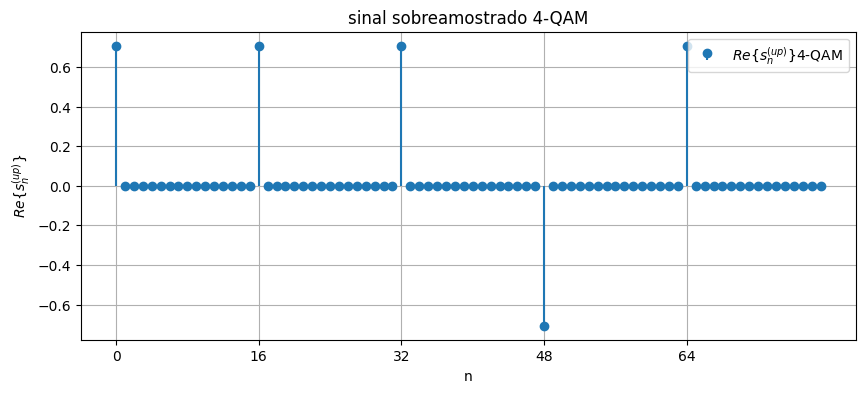

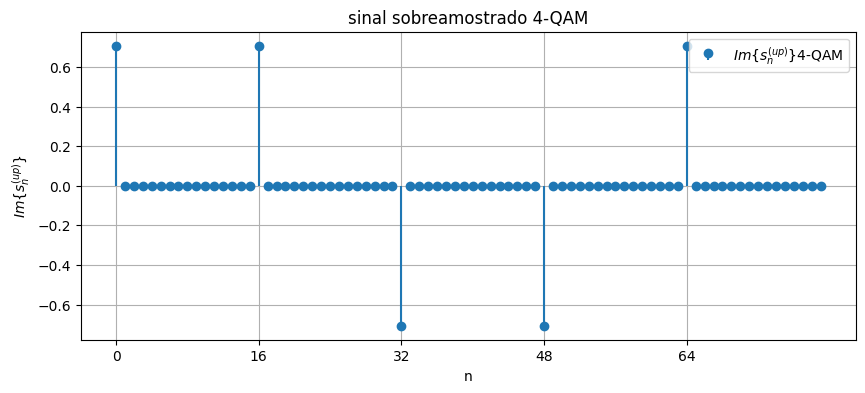

In [46]:
plt.figure(1, figsize=(10, 4))
plt.stem(symbolsUp[0:5*SpS].real, basefmt=" ", label ='$Re\{s_n^{(up)}\}$'+str(M)+'-QAM')
plt.xlabel('n')
plt.ylabel('$Re\{s_n^{(up)}\}$')
plt.legend(loc='upper right')
plt.xticks(np.arange(0, 5*SpS, SpS))
plt.title('sinal sobreamostrado '+str(M)+'-QAM')
plt.grid();

plt.figure(2, figsize=(10, 4))
plt.stem(symbolsUp[0:5*SpS].imag, basefmt=" ", label ='$Im\{s_n^{(up)}\}$'+str(M)+'-QAM')
plt.xlabel('n')
plt.ylabel('$Im\{s_n^{(up)}\}$')
plt.legend(loc='upper right')
plt.xticks(np.arange(0, 5*SpS, SpS))
plt.title('sinal sobreamostrado '+str(M)+'-QAM')
plt.grid();

/home/silas/miniconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/silas/miniconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


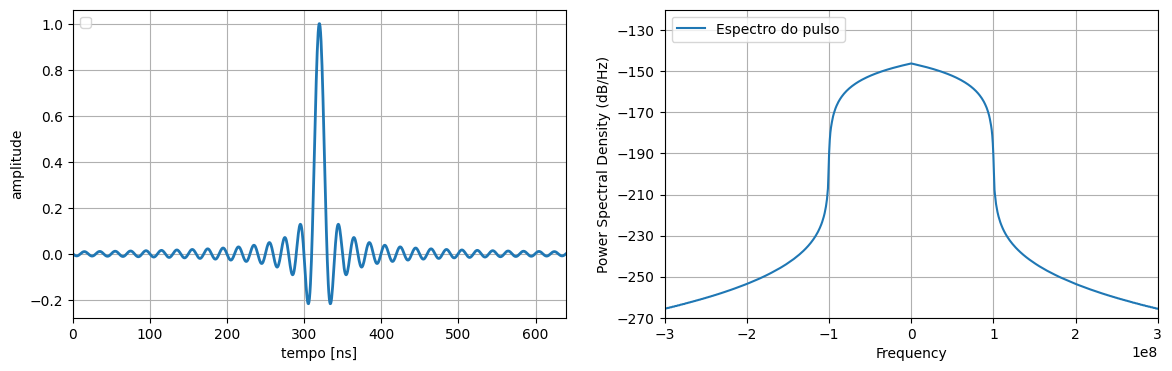

In [47]:
# pulso NRZ típico
pulse = pulseShape('rc', SpS, N=1024, alpha=0.01)
pulse = np.array(pulse/max(abs(pulse)), dtype=np.complex64)

t = np.arange(pulse.size)*(Ta/1e-9)

fig, axs = plt.subplots(1, 2, figsize=(14, 4))
axs[0].plot(t, pulse, '-', linewidth=2)
axs[0].set_xlabel('tempo [ns]')
axs[0].set_ylabel('amplitude')
axs[0].set_xlim(min(t), max(t))
axs[0].legend(loc='upper left');
axs[0].grid(True)

# plot psd
axs[1].set_xlim(-3*Rs, 3*Rs)
axs[1].set_ylim(-270, -120)
axs[1].psd(np.abs(pulse)**2, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do pulso')
axs[1].legend(loc='upper left');

## Formatação de Pulso

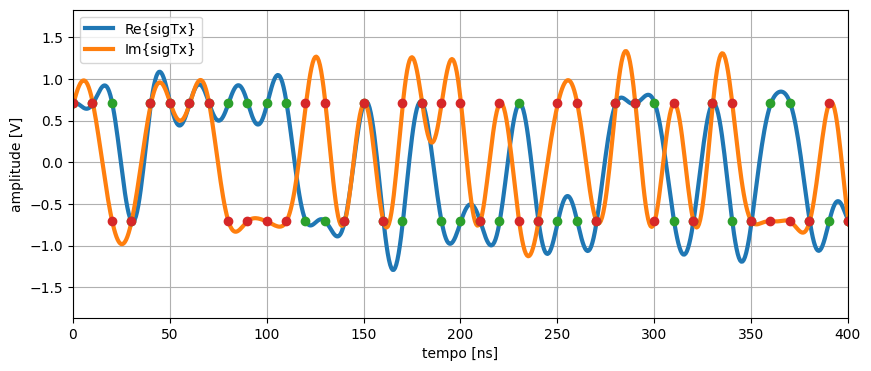

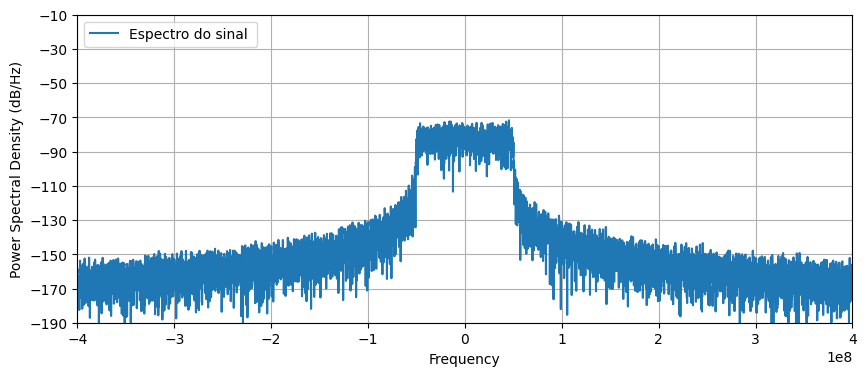

In [48]:
sigTx = dsp.firFilter(symbolsUp, pulse, symbolsUp.size, pulse.size)
sigTx = c2py(sigTx, symbolsUp.size)

t = np.arange(0, sigTx.size)*(Ta)/1e-9

# instantes centrais de sinalização.
symbolsUp[symbolsUp==0+1j*0] = np.nan + 1j*np.nan

plt.figure(1, figsize=(10, 4))
plt.plot(t, sigTx.real, '-', linewidth=3, label='Re{sigTx}')
plt.plot(t, sigTx.imag, '-', linewidth=3, label='Im{sigTx}')
plt.plot(t, symbolsUp.real, 'o') 
plt.plot(t, symbolsUp.imag, 'o') 
plt.xlim(min(t), 400)
plt.xlabel('tempo [ns]')
plt.ylabel('amplitude [V]')
plt.legend(loc='upper left')
plt.grid(True)

# plot psd
plt.figure(figsize=(10, 4))
plt.xlim(-4*Rs, 4*Rs)
plt.ylim(-190, -10)
plt.psd(sigTx, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal ')
plt.legend(loc='upper left');

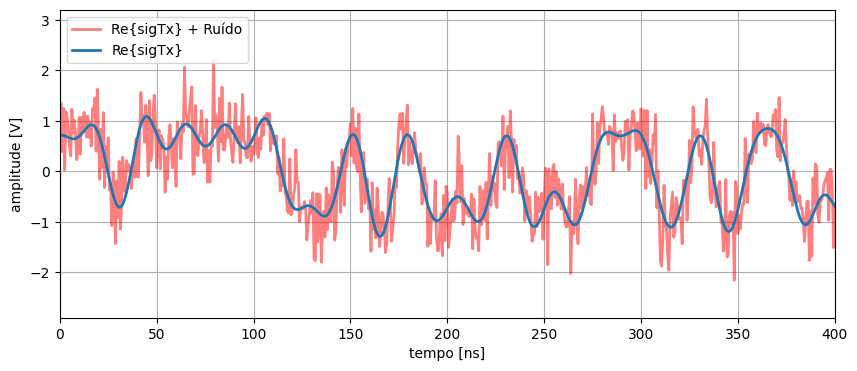

In [49]:
# ruído gaussiano branco
Namostras = sigTx.size
σ2  = 0.025  # variância
μ   = 0      # média
σ      = np.sqrt(σ2*SpS) 

ruido  = 1/np.sqrt(2)*(np.random.normal(μ, σ, Namostras) + 1j*np.random.normal(μ, σ, Namostras))
sigCh = np.array(sigTx + ruido, dtype=np.complex64)

t = np.arange(0, sigTx.size)*(Ta)/1e-9

plt.figure(None, figsize=(10, 4))
plt.plot(t, sigTx.real + ruido, '-', linewidth=2, alpha=0.5, label='Re{sigTx} + Ruído', color='r')
plt.plot(t, sigTx.real, '-', linewidth=2, label='Re{sigTx}')
plt.xlim(min(t), 400)
plt.xlabel('tempo [ns]')
plt.ylabel('amplitude [V]')
plt.legend(loc='upper left')
plt.grid(True);

## Filtro casado

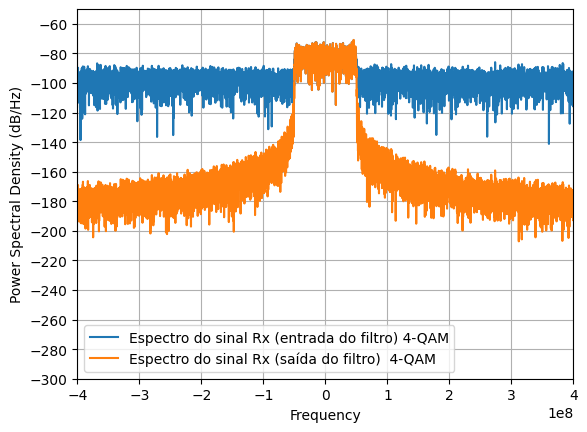

In [50]:
sigRx = dsp.matchedFilter(sigCh, pulse, sigCh.size, pulse.size)
sigRx = c2py(sigRx, sigCh.size)

# plot PSD
plt.figure();
plt.xlim(-4*Rs,4*Rs);
plt.ylim(-300,-50);
plt.psd(sigTx+ruido,Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal Rx (entrada do filtro) '+ str(M) +'-QAM')
plt.psd(sigRx, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal Rx (saída do filtro)  '+ str(M) +'-QAM')
plt.legend(loc='lower left');

## Aplica a decisão ótima

In [52]:
sigDecimate = dsp.downsample(sigRx, sigRx.size, SpS)
sigDecimate = c2py(sigDecimate, int(sigRx.size/SpS))

# Decisão Ótima
decision_c = dsp.MLdetector(sigDecimate, constSymb, constSymb.size, sigDecimate.size)
decision_c = c2py(decision_c, sigDecimate.size)

# ind = np.arange(100,decision_c.size-100)
# SER = 1 - np.sum( np.isclose(decision_c[ind], symbTx[ind], rtol=1e-2))/decision_c.size # calcula SER
# SNRb = 10*np.log10(signal_power(sigTx)/σ2/np.log2(M))

# print(f'SNRb = {SNRb:.2f} dB')
# print(f'SER = {SER:.2e}')